                                                        John Luke Lim

This project replicates and extends a prior R-based analysis by implementing a full end-to-end machine learning pipeliine in python to predict diabetes risk.

The objective is to compare multiple classification models for diabetes risk prediction, with emphasis on the False Negative Rate metric (FNR) and recall and ROC-AUC. This reflects the importance of minimising false negatives in healthcare risk prediction.

## Dataset Overview

The dataset provided by Mohammed Mustafa on Kaggle consists of 10,000 rows of data, containing patient-level health indicators used to predict diabetes status.
* Target variable: 'diabetes' (0 = non-diabetic, 1 = diabetic)
* Mixture of quantitative and categorical features
* Class imbalance present

This project prioritises minimising false negatives to reduce missed diabetes cases.

In [9]:
%matplotlib inline

# Core data handling
import numpy as np
import pandas as pd
import math

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import fisher_exact
from sklearn.calibration import calibration_curve

# Data splitting & preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    f1_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

# Reproducibility
RANDOM_STATE = 611

print("Setup successful")


Setup successful


In [10]:
df = pd.read_csv("diabetes-dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## Initial Data Inspection

We begin this project by inspecting the structure, data types, and summary statistics to understand feature distributions and identify potential preprocessing needs.

In [11]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [12]:
# Response variable
df["diabetes"] = df["diabetes"].astype(int)

# Categorical features
cat_features = [
    "gender",
    "hypertension",
    "heart_disease",
    "smoking_history"
]

df[cat_features] = df[cat_features].astype("category")

In [13]:
# X is the dataset consisting of input variables
X = df.drop(columns = 'diabetes')

# Y is the dataset consisting of the response variable (diabetes)
y = df["diabetes"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, # test size 20% and train set 80%
    stratify=y, # class imabalance preserved
    random_state=611
)

y_train.value_counts(normalize=True)
# the ouput shows that 91.5% of the train set is class 0 (without diabetes) and 8.5% 
# is class 1 (with diabetes)

diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64

In [14]:
num_features = [
    "age",
    "bmi",
    "HbA1c_level",
    "blood_glucose_level"
]

preprocess_all = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first"), cat_features)
    ]
)

preprocess_knn = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features)
    ]
)
# the code above scales the data to allow for the used of distance-based methods
# for analysis

In [15]:
models = {
    "Logistic Regression": Pipeline([
        ("prep", preprocess_all),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "Decision Tree": Pipeline([
        ("prep", preprocess_all),
        ("model", DecisionTreeClassifier(random_state=611))
    ]),
    "KNN": Pipeline([
        ("prep", preprocess_knn),
        ("model", KNeighborsClassifier())
    ]),
    "Random Forest": Pipeline([
        ("prep", preprocess_all),
        ("model", RandomForestClassifier(
            n_estimators=200,
            random_state=611,
            n_jobs=-1
        ))
    ])
}

In [16]:
# Store results
results = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Predict probabilities for ROC-AUC
    if hasattr(model.named_steps['model'], "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = y_pred  # For models without predict_proba (non-logistic regression models), fallback to labels
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Store results
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "ROC-AUC": roc_auc
    })

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Recall", ascending=False)  # sort by recall for healthcare focus
results_df


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
1,Decision Tree,0.95070,0.701923,0.730000,0.715686,0.850761
3,Random Forest,0.97035,0.951837,0.685882,0.797265,0.964781
2,KNN,0.96680,0.919773,0.667647,0.773688,0.907276
0,Logistic Regression,0.96130,0.877036,0.633529,0.735656,0.961565


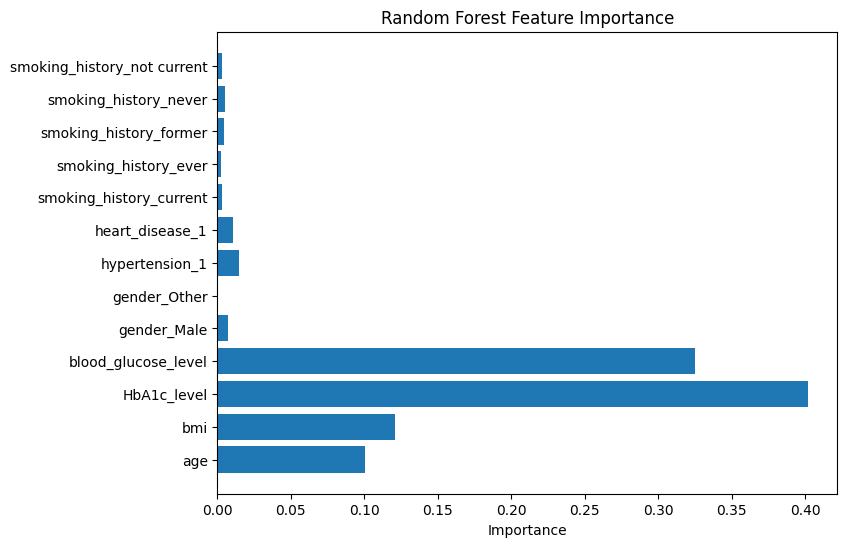

In [17]:
# Random Forest feature importance
rf_model = models["Random Forest"]

# Get feature names after preprocessing
feature_names = (
    num_features + 
    list(rf_model.named_steps['prep'].named_transformers_['cat'].get_feature_names_out())
)

# Get feature importances
importances = rf_model.named_steps['model'].feature_importances_

# Plot
plt.figure(figsize=(8,6))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.show()


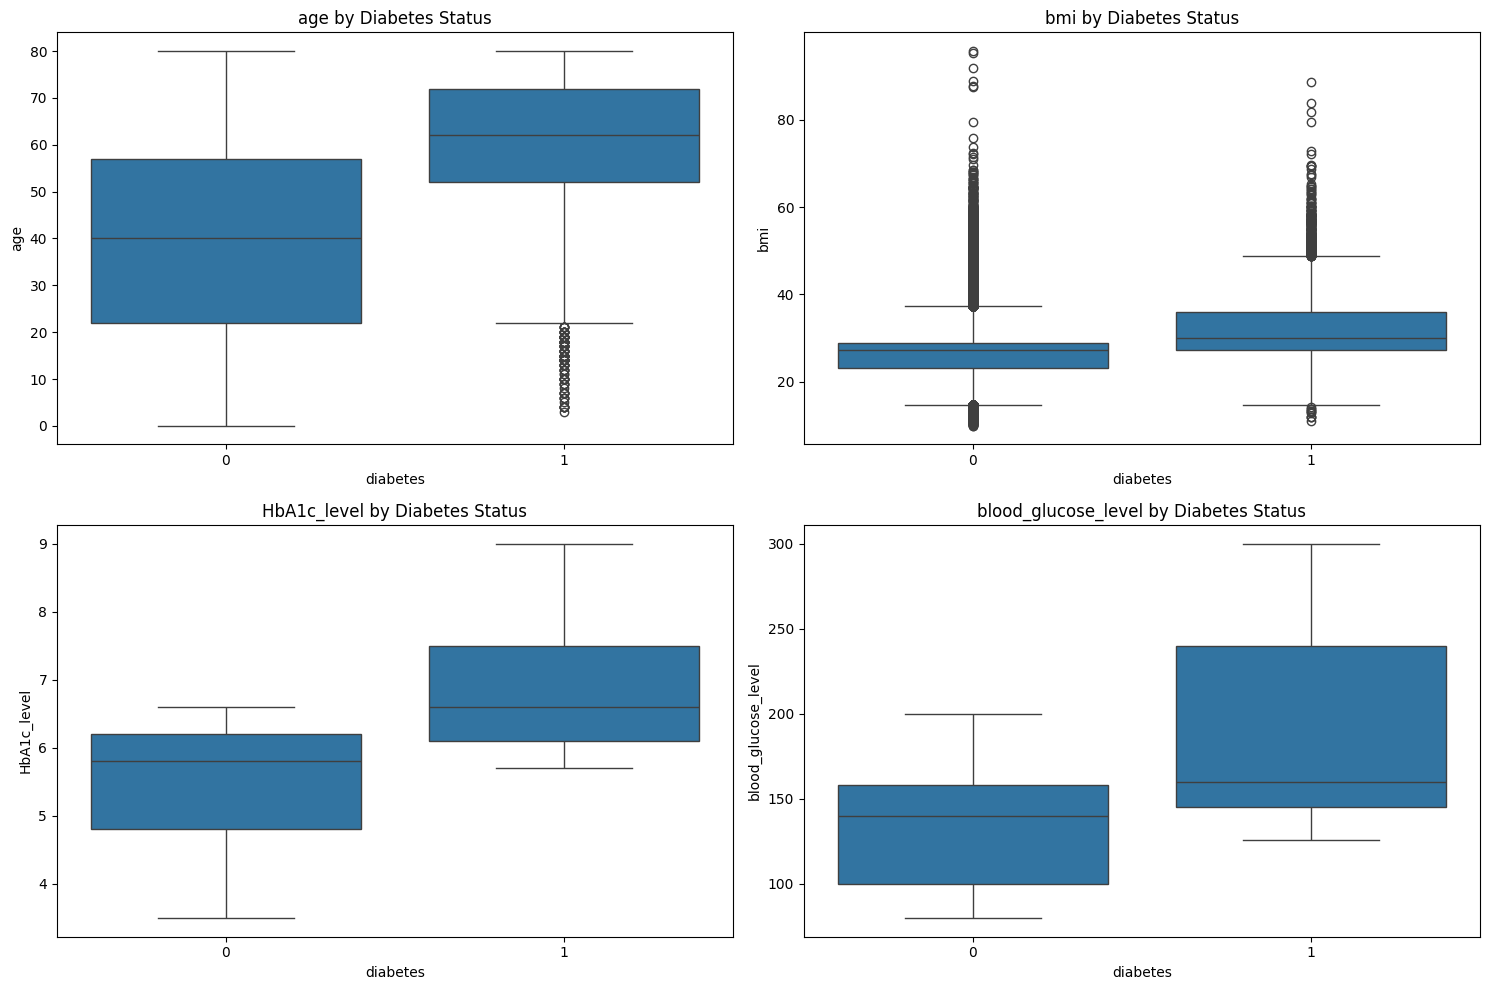

In [18]:
## Visualisation of data provided from dataset

# Visualisation of numeric data with diabetes status

numeric_features = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]

plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x="diabetes", y=col, data=df)
    plt.title(f"{col} by Diabetes Status")
plt.tight_layout()
plt.show()


In [19]:
# boxplots of categorical features with diabetes status

for col in cat_features:
    print(f"Feature: {col}")
    table = pd.crosstab(df[col], df["diabetes"])
    print(table)
    
    # Compute odds ratio for binary categorical features
    if table.shape == (2,2):
        odds_ratio, p_value = fisher_exact(table)
        print(f"Odds Ratio: {odds_ratio:.2f}, p-value: {p_value:.3f}")
    print("\n")

Feature: gender
diabetes      0     1
gender               
Female    54091  4461
Male      37391  4039
Other        18     0


Feature: hypertension
diabetes          0     1
hypertension             
0             86103  6412
1              5397  2088
Odds Ratio: 5.20, p-value: 0.000


Feature: heart_disease
diabetes           0     1
heart_disease             
0              88825  7233
1               2675  1267
Odds Ratio: 5.82, p-value: 0.000


Feature: smoking_history
diabetes             0     1
smoking_history             
No Info          34362  1454
current           8338   948
ever              3532   472
former            7762  1590
never            31749  3346
not current       5757   690




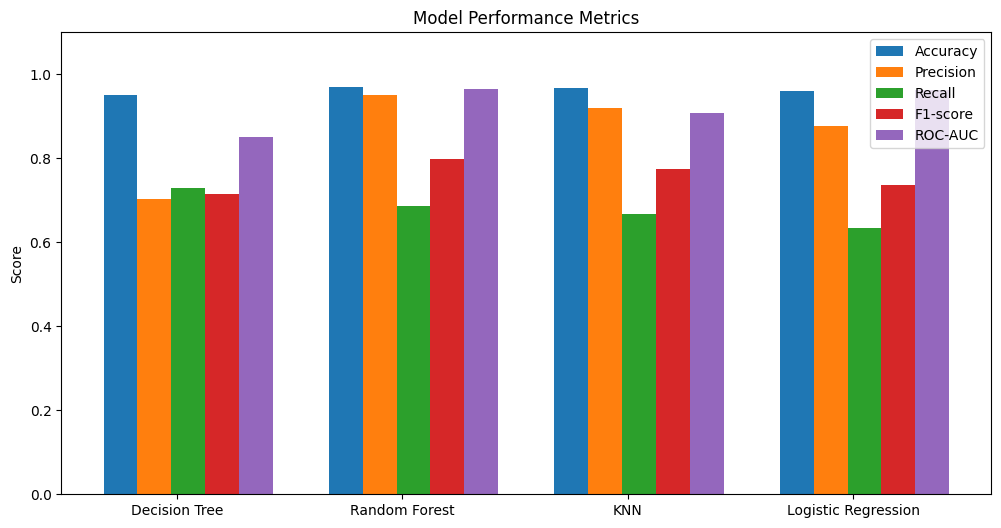

In [20]:
# From the above results of the different metrics stores in results_df, I plot a bar chart

metrics = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]

# Set figure size
plt.figure(figsize=(12,6))

# Plot each metric as grouped bar chart
for i, metric in enumerate(metrics):
    plt.bar(
        x=np.arange(len(results_df)) + i*0.15, 
        height=results_df[metric], 
        width=0.15, 
        label=metric
    )

plt.xticks(np.arange(len(results_df)) + 0.25, results_df["Model"])
plt.ylim(0,1.1)
plt.ylabel("Score")
plt.title("Model Performance Metrics")
plt.legend()
plt.show()


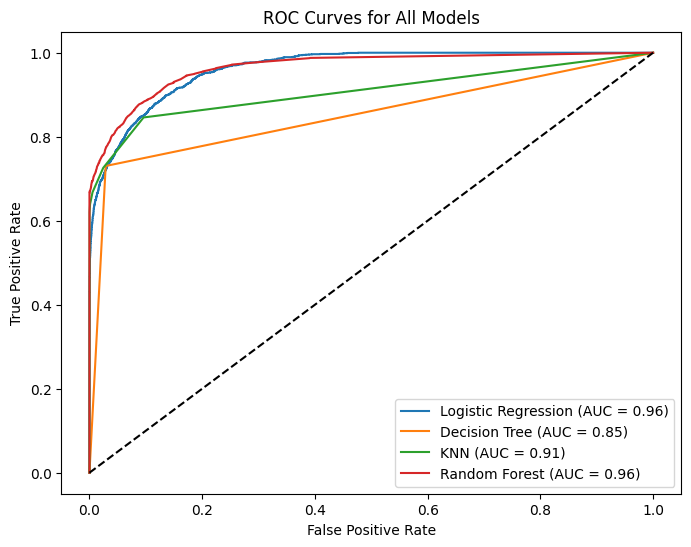

In [21]:
# ROC curve for all models for comparison

plt.figure(figsize=(8,6))

for name, model in models.items():
    if hasattr(model.named_steps['model'], "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        # fallback for models without probabilities
        y_proba = model.predict(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.show()


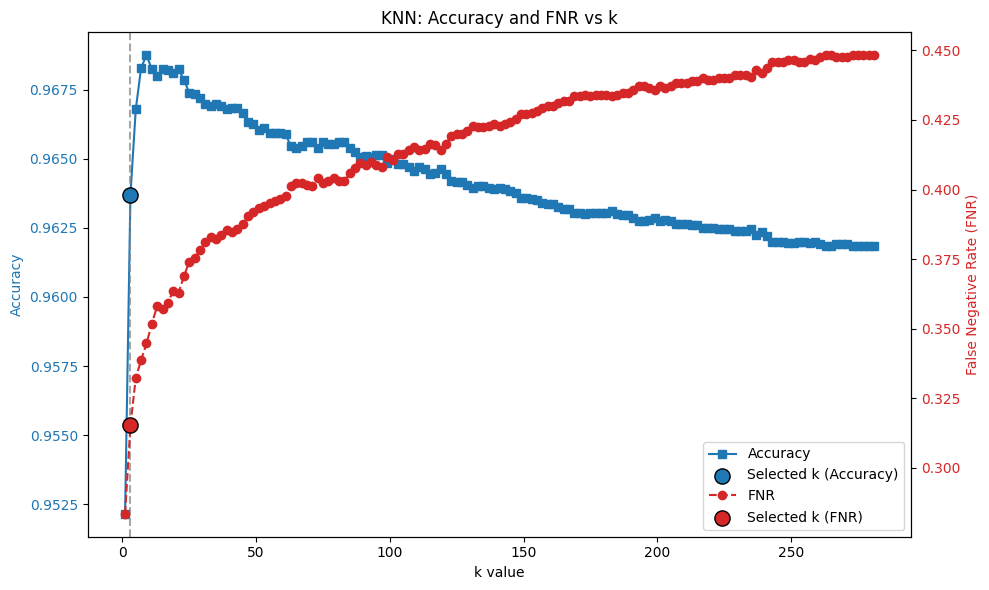

In [22]:
# Hyperparameter tuning: KNN FNR and Accuracy vs k
max_k = int(math.sqrt(len(X_train)))  # ≈283
k_values = list(range(1, max_k + 1, 2))  # odd numbers only

fnr_values = []
accuracy_values = []

for k in k_values:
    knn = Pipeline([
        ("prep", preprocess_knn),
        ("model", KNeighborsClassifier(n_neighbors=k))
    ])
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # False Negative Rate
    fnr = sum((y_test==1) & (y_pred==0)) / sum(y_test==1)
    fnr_values.append(fnr)
    
    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_values.append(acc)

# Plot
best_k = 3

fig, ax1 = plt.subplots(figsize=(10,6))

# Accuracy line (left axis)
ax1.plot(k_values, accuracy_values, marker='s', color='tab:blue', label='Accuracy')
ax1.set_xlabel("k value")
ax1.set_ylabel("Accuracy", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Highlight selected k for Accuracy
ax1.scatter(best_k, accuracy_values[k_values.index(best_k)],
            color='tab:blue', s=120, zorder=5, edgecolor='black', label='Selected k (Accuracy)')

# Vertical line for selected k
ax1.axvline(best_k, linestyle='--', color='gray', alpha=0.7)

# FNR line (right axis)
ax2 = ax1.twinx()
ax2.plot(k_values, fnr_values, marker='o', linestyle='--', color='tab:red', label='FNR')
ax2.set_ylabel("False Negative Rate (FNR)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Highlight selected k for FNR
ax2.scatter(best_k, fnr_values[k_values.index(best_k)],
            color='tab:red', s=120, zorder=5, edgecolor='black', label='Selected k (FNR)')

# Annotation: move label to x-axis
ax1.annotate(f"Selected k = {best_k}",
             xy=(best_k, 0),  # point at x-axis
             xytext=(best_k + 2, max(accuracy_values)),  # label location
             arrowprops=dict(facecolor='black', arrowstyle='-|>'),
             fontsize=10,
             color='black')

# Combine legends and move to bottom right
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', frameon=True)

plt.title("KNN: Accuracy and FNR vs k")
plt.tight_layout()
plt.show()


Best max_depth (lowest CV FNR): 26
Corresponding CV FNR: 0.2640


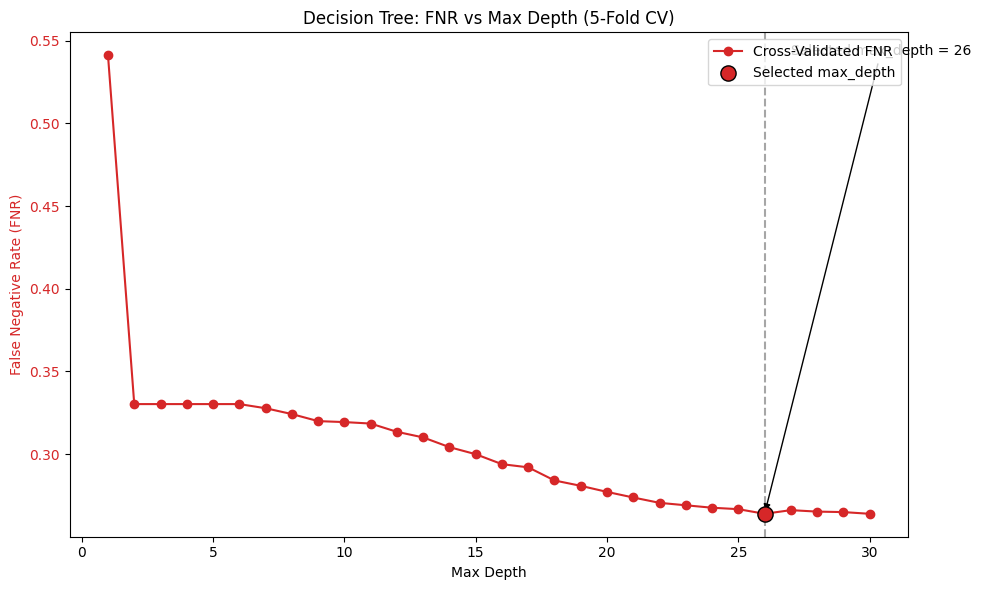

In [25]:
# Range of max_depth values to test
max_depth_values = list(range(1, 31))

# Store cross-validated FNR
fnr_cv = []

# Stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for depth in max_depth_values:
    dt = Pipeline([
        ("prep", preprocess_all),
        ("model", DecisionTreeClassifier(
            max_depth=depth,
            random_state=RANDOM_STATE
        ))
    ])

    fold_fnr = []

    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dt.fit(X_tr, y_tr)
        y_val_pred = dt.predict(X_val)

        # False Negative Rate
        fnr = np.sum((y_val == 1) & (y_val_pred == 0)) / np.sum(y_val == 1)
        fold_fnr.append(fnr)

    fnr_cv.append(np.mean(fold_fnr))

# ==============================
# Select best max_depth (lowest FNR)
# ==============================

best_idx = np.argmin(fnr_cv)
best_depth = max_depth_values[best_idx]
best_fnr = fnr_cv[best_idx]

print(f"Best max_depth (lowest CV FNR): {best_depth}")
print(f"Corresponding CV FNR: {best_fnr:.4f}")

# ==============================
# Plot: FNR vs max_depth
# ==============================

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(max_depth_values, fnr_cv,
        marker='o',
        linestyle='-',
        color='tab:red',
        label='Cross-Validated FNR')

ax.set_xlabel("Max Depth")
ax.set_ylabel("False Negative Rate (FNR)", color='tab:red')
ax.tick_params(axis='y', labelcolor='tab:red')

# Highlight best depth
ax.scatter(best_depth, best_fnr,
           s=120,
           color='tab:red',
           edgecolor='black',
           zorder=5,
           label='Selected max_depth')

ax.axvline(best_depth,
           linestyle='--',
           color='gray',
           alpha=0.7)

ax.annotate(f"Selected max_depth = {best_depth}",
            xy=(best_depth, best_fnr),
            xytext=(best_depth + 1, max(fnr_cv)),
            arrowprops=dict(arrowstyle='-|>', color='black'),
            fontsize=10)

ax.legend(loc='upper right')
plt.title("Decision Tree: FNR vs Max Depth (5-Fold CV)")
plt.tight_layout()
plt.show()

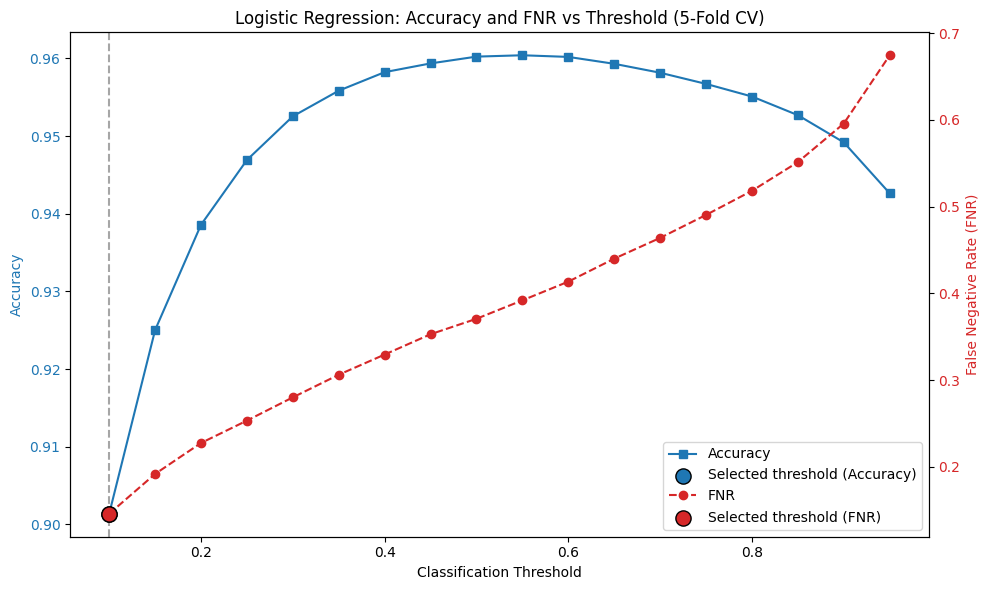

Best threshold (lowest FNR, CV): 0.10
Intercept: -5.8880038554892105

Top coefficients:
                             Feature  Coefficient
2                   num__HbA1c_level     2.519667
3           num__blood_glucose_level     1.365061
0                           num__age     1.012964
8       cat__smoking_history_current     0.758906
7               cat__heart_disease_1     0.751511
6                cat__hypertension_1     0.742199
9          cat__smoking_history_ever     0.638195
10       cat__smoking_history_former     0.623877
1                           num__bmi     0.586580
11        cat__smoking_history_never     0.548500
12  cat__smoking_history_not current     0.539946
4                   cat__gender_Male     0.252529
5                  cat__gender_Other    -0.008368


In [26]:
# Hyperparameter tuning: Logistic Regression (LR) FNR and accuracy vs threshold

# Rather than a "norm" like taking the square root of the number of rows in the
# train dataset like KNN, I use a reasonable range of threshold values to test, 
# with not too many intervals of data to reduce computational time and
# N-Fold cross validation to ensure it is the best hyperparameter. An average across
# folds are then taken

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

thresholds = np.arange(0.1, 1.0, 0.05)
fnr_values = np.zeros(len(thresholds))
accuracy_values = np.zeros(len(thresholds))

for train_index, val_index in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Fit logistic regression on current fold
    logreg = Pipeline([
        ("prep", preprocess_all),
        ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
    ])
    logreg.fit(X_tr, y_tr)
    y_proba = logreg.predict_proba(X_val)[:,1]

    # Evaluate thresholds
    for i, t in enumerate(thresholds):
        y_pred = (y_proba >= t).astype(int)
        fnr_values[i] += sum((y_val==1) & (y_pred==0)) / sum(y_val==1)
        accuracy_values[i] += accuracy_score(y_val, y_pred)

# Average over folds
fnr_values /= kf.get_n_splits()
accuracy_values /= kf.get_n_splits()

# Best threshold index
best_idx = np.argmin(fnr_values)
best_threshold = thresholds[best_idx]

fig, ax1 = plt.subplots(figsize=(10,6))

# Accuracy line (left axis)
ax1.plot(thresholds, accuracy_values, marker='s', color='tab:blue', label='Accuracy')
ax1.set_xlabel("Classification Threshold")
ax1.set_ylabel("Accuracy", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Highlight selected threshold for Accuracy
ax1.scatter(best_threshold, accuracy_values[best_idx],
            color='tab:blue', s=120, edgecolor='black', zorder=5, label='Selected threshold (Accuracy)')

# Vertical line at selected threshold
ax1.axvline(best_threshold, linestyle='--', color='gray', alpha=0.7)

# FNR line (right axis)
ax2 = ax1.twinx()
ax2.plot(thresholds, fnr_values, marker='o', linestyle='--', color='tab:red', label='FNR')
ax2.set_ylabel("False Negative Rate (FNR)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Highlight selected threshold for FNR
ax2.scatter(best_threshold, fnr_values[best_idx],
            color='tab:red', s=120, edgecolor='black', zorder=5, label='Selected threshold (FNR)')

# Annotation from x-axis
ax1.annotate(f"Selected threshold = {best_threshold:.2f}",
             xy=(best_threshold, 0),
             xytext=(best_threshold + 0.05, max(max(fnr_values), max(accuracy_values))),
             arrowprops=dict(facecolor='black', arrowstyle='-|>'),
             fontsize=10,
             color='black')

# Combine legends and move to bottom right
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', frameon=True)

plt.title("Logistic Regression: Accuracy and FNR vs Threshold (5-Fold CV)")
plt.tight_layout()
plt.show()

best_threshold = thresholds[np.argmin(fnr_values)]
print(f"Best threshold (lowest FNR, CV): {best_threshold:.2f}")

final_lr = Pipeline([
    ("prep", preprocess_all),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

final_lr.fit(X_train, y_train)

# Extract trained logistic regression model
lr_model = final_lr.named_steps["model"]

# Get feature names AFTER preprocessing
feature_names = final_lr.named_steps["prep"].get_feature_names_out()

# Coefficients and intercept
coefficients = lr_model.coef_[0]
intercept = lr_model.intercept_[0]

# Put into a clean table (optional but very useful)
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("Intercept:", intercept)
print("\nTop coefficients:")
print(coef_df.head(15))

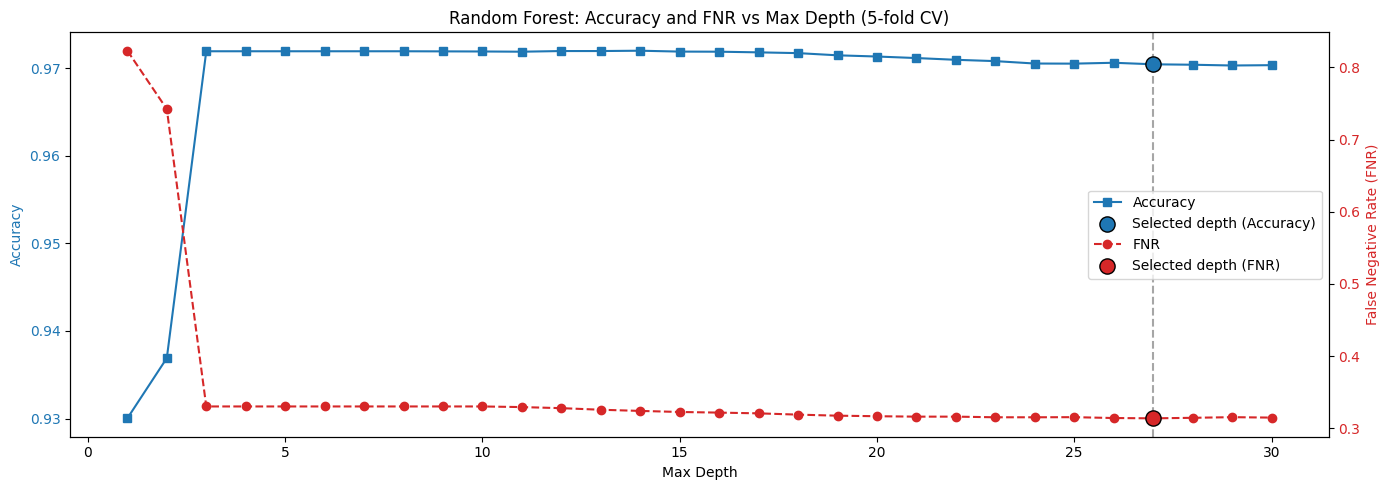

Best max_depth (lowest FNR): 27


In [27]:
# Hyperparameter tuning: Random Forest FNR vs max_depth

# The max_depth and thought process is similar to the original decision tree
# hyperparameter tuning

max_depth_values = list(range(1, 31))
fnr_values = []
accuracy_values = []

# Use StratifiedKFold to maintain class balance in CV
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

for depth in max_depth_values:
    fnr_fold = []
    acc_fold = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        rf = Pipeline([
            ("prep", preprocess_all),
            ("model", RandomForestClassifier(
                n_estimators=200,
                max_depth=depth,
                random_state=RANDOM_STATE,
                n_jobs=-1
            ))
        ])
        
        rf.fit(X_tr, y_tr)
        y_pred = rf.predict(X_val)
        
        # FNR = FN / (FN + TP)
        fnr = sum((y_val==1) & (y_pred==0)) / sum(y_val==1)
        fnr_fold.append(fnr)
        
        acc = accuracy_score(y_val, y_pred)
        acc_fold.append(acc)
    
    # Average across folds
    fnr_values.append(np.mean(fnr_fold))
    accuracy_values.append(np.mean(acc_fold))

best_depth = 27
best_idx = max_depth_values.index(best_depth)

fig, ax1 = plt.subplots(figsize=(14,5))  # wider, shorter figure

# Accuracy line (left axis)
ax1.plot(max_depth_values, accuracy_values, marker='s', color='tab:blue', label='Accuracy')
ax1.set_xlabel("Max Depth")
ax1.set_ylabel("Accuracy", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Highlight selected depth for Accuracy
ax1.scatter(best_depth, accuracy_values[best_idx],
            color='tab:blue', s=120, edgecolor='black', zorder=5, label='Selected depth (Accuracy)')

# Vertical line for selected depth
ax1.axvline(best_depth, linestyle='--', color='gray', alpha=0.7)

# FNR line (right axis)
ax2 = ax1.twinx()
ax2.plot(max_depth_values, fnr_values, marker='o', linestyle='--', color='tab:red', label='FNR')
ax2.set_ylabel("False Negative Rate (FNR)", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Highlight selected depth for FNR
ax2.scatter(best_depth, fnr_values[best_idx],
            color='tab:red', s=120, edgecolor='black', zorder=5, label='Selected depth (FNR)')

# Annotation from x-axis (place text ~80% of y-range)
ymax = max(max(accuracy_values), max(fnr_values))
ax1.annotate(f"Selected depth = {best_depth}",
             xy=(best_depth, 0),
             xytext=(best_depth + 1, ymax * 0.8),
             arrowprops=dict(facecolor='black', arrowstyle='-|>'),
             fontsize=10,
             color='black')

# Combine legends and move to middle right
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', frameon=True)

plt.title(f"Random Forest: Accuracy and FNR vs Max Depth ({n_splits}-fold CV)")
plt.tight_layout()  # ensures the figure fits fully
plt.show()

print(f"Best max_depth (lowest FNR): {best_depth}")


In [28]:
# Final best hyperparameters of each model

BEST_KNN_K = 3
BEST_DT_MAX_DEPTH = 26
BEST_LR_THRESHOLD = 0.10
BEST_RF_MAX_DEPTH = 27

In [29]:
# Logistic Regression
final_lr = Pipeline([
    ("prep", preprocess_all),
    ("model", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])
final_lr.fit(X_train, y_train)

# KNN
final_knn = Pipeline([
    ("prep", preprocess_knn),
    ("model", KNeighborsClassifier(n_neighbors=best_k))
])
final_knn.fit(X_train, y_train)

# Decision Tree
final_dt = Pipeline([
    ("prep", preprocess_all),
    ("model", DecisionTreeClassifier(max_depth=best_depth, random_state=RANDOM_STATE))
])
final_dt.fit(X_train, y_train)

# Random Forest
final_rf = Pipeline([
    ("prep", preprocess_all),
    ("model", RandomForestClassifier(n_estimators=200,
                                     max_depth=27,
                                     random_state=RANDOM_STATE,
                                     n_jobs=-1))
])
final_rf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains s

In [30]:
def evaluate_model(model, X_test, y_test, name="Model", threshold=None):
    if threshold is not None:  # Only for LR threshold adjustment
        y_proba = model.predict_proba(X_test)[:,1]
        y_pred = (y_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    fnr = sum((y_test==1) & (y_pred==0)) / sum(y_test==1)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"{name} -> Accuracy: {accuracy:.4f}, FNR: {fnr:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    return accuracy, fnr


# Evaluate all models
print("Logistic Regression (with threshold adjustment):")
lr_acc, lr_fnr = evaluate_model(final_lr, X_test, y_test, name="Logistic Regression", threshold=best_threshold)

print("\nKNN:")
knn_acc, knn_fnr = evaluate_model(final_knn, X_test, y_test, name="KNN")

print("\nDecision Tree:")
dt_acc, dt_fnr = evaluate_model(final_dt, X_test, y_test, name="Decision Tree")

print("\nRandom Forest:")
rf_acc, rf_fnr = evaluate_model(final_rf, X_test, y_test, name="Random Forest")



Logistic Regression (with threshold adjustment):
Logistic Regression -> Accuracy: 0.8976, FNR: 0.1465
Confusion Matrix:
[[16502  1798]
 [  249  1451]]

KNN:
KNN -> Accuracy: 0.9637, FNR: 0.3153
Confusion Matrix:
[[18110   190]
 [  536  1164]]

Decision Tree:
Decision Tree -> Accuracy: 0.9523, FNR: 0.2665
Confusion Matrix:
[[17798   502]
 [  453  1247]]

Random Forest:
Random Forest -> Accuracy: 0.9703, FNR: 0.3176
Confusion Matrix:
[[18246    54]
 [  540  1160]]


In [31]:
# Function to get transformed feature names from ColumnTransformer
def get_feature_names(preprocessor):
    names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                names.extend(transformer.get_feature_names_out(cols))
            else:
                names.extend(cols)
    return names

# Random Forest Feature Importance
rf_importances = final_rf.named_steps['model'].feature_importances_
feature_names = get_feature_names(final_rf.named_steps['prep'])
rf_feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_importances
}).sort_values("Importance", ascending=False)

print("\nRandom Forest Top 10 Feature Importances:")
print(rf_feat_df.head(10))

# Logistic Regression Coefficients
lr_coefs = final_lr.named_steps['model'].coef_[0]
feature_names = get_feature_names(final_lr.named_steps['prep'])
lr_feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lr_coefs
})
lr_feat_df["AbsCoef"] = lr_feat_df["Coefficient"].abs()  # <- fix here
lr_feat_df.sort_values("AbsCoef", ascending=False, inplace=True)

print("\nLogistic Regression Top 10 Features by Coefficient Magnitude:")
print(lr_feat_df.head(10))




Random Forest Top 10 Feature Importances:
                    Feature  Importance
2               HbA1c_level    0.400889
3       blood_glucose_level    0.328353
1                       bmi    0.120823
0                       age    0.098445
6            hypertension_1    0.014781
7           heart_disease_1    0.010314
4               gender_Male    0.007333
11    smoking_history_never    0.005475
10   smoking_history_former    0.004574
8   smoking_history_current    0.003385

Logistic Regression Top 10 Features by Coefficient Magnitude:
                    Feature  Coefficient   AbsCoef
2               HbA1c_level     2.519667  2.519667
3       blood_glucose_level     1.365061  1.365061
0                       age     1.012964  1.012964
8   smoking_history_current     0.758906  0.758906
7           heart_disease_1     0.751511  0.751511
6            hypertension_1     0.742199  0.742199
9      smoking_history_ever     0.638195  0.638195
10   smoking_history_former     0.623877  0.62

In [32]:
# Evaluate final models using tuned hyperparameters
final_models = {
    "Logistic Regression": (final_lr, best_threshold),
    "KNN": (final_knn, None),
    "Decision Tree": (final_dt, None),
    "Random Forest": (final_rf, None)
}

summary = []

for name, (model, threshold) in final_models.items():
    if threshold:
        y_proba = model.predict_proba(X_test)[:,1]
        y_pred = (y_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
        if hasattr(model.named_steps['model'], "predict_proba"):
            y_proba = model.predict_proba(X_test)[:,1]
        else:
            y_proba = y_pred
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    fnr = sum((y_test==1) & (y_pred==0)) / sum(y_test==1)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    summary.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "FNR": fnr,
        "ROC-AUC": roc_auc
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values("Recall", ascending=False)  # focus on healthcare metric
summary_df


,Model,Accuracy,Precision,Recall,F1,FNR,ROC-AUC
0,Logistic Regression,0.89765,0.446599,0.853529,0.586381,0.146471,0.961565
2,Decision Tree,0.95225,0.712979,0.733529,0.723108,0.266471,0.855214
1,KNN,0.96370,0.859675,0.684706,0.762279,0.315294,0.881698
3,Random Forest,0.97030,0.955519,0.682353,0.796156,0.317647,0.967358


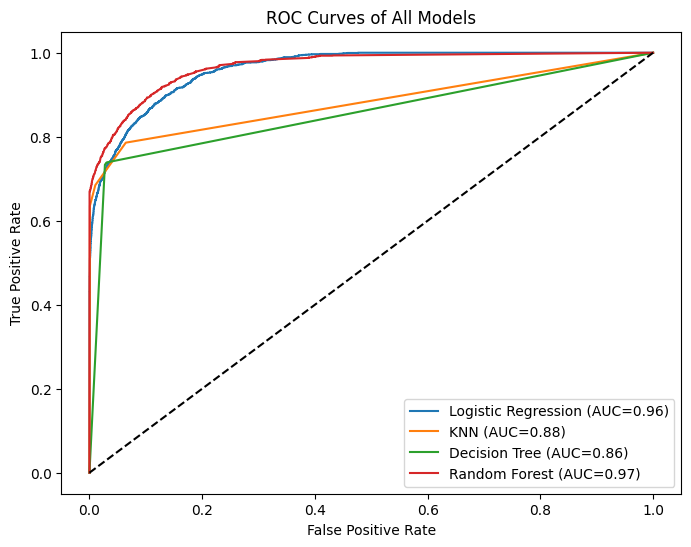

In [33]:
plt.figure(figsize=(8,6))

for name, (model, threshold) in final_models.items():
    if threshold:
        y_proba = model.predict_proba(X_test)[:,1]
    elif hasattr(model.named_steps['model'], "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = model.predict(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves of All Models")
plt.legend(loc="lower right")
plt.show()


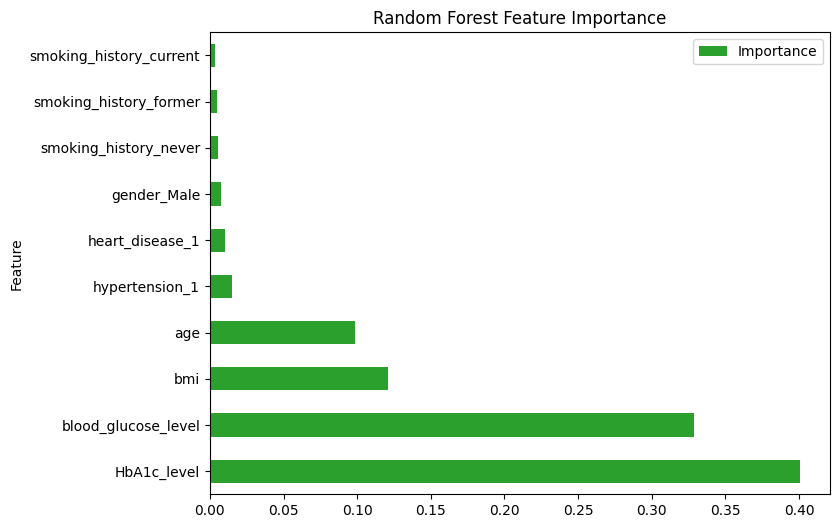

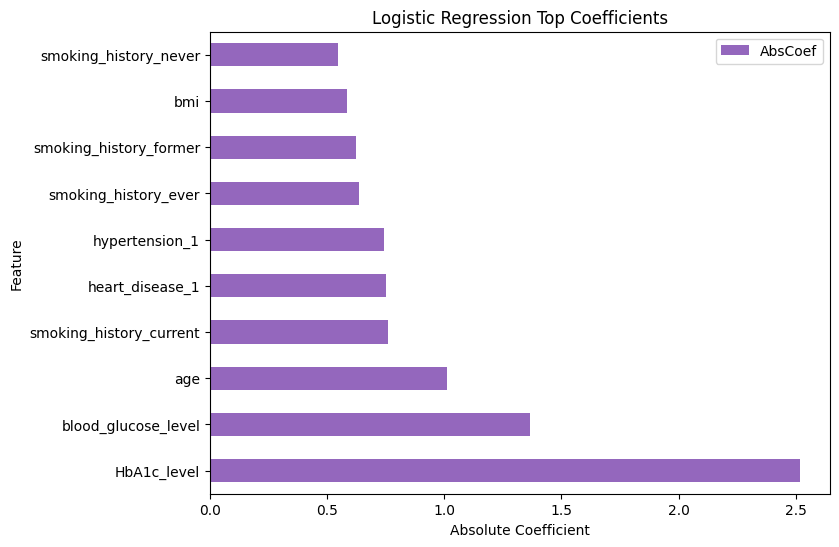

In [34]:
# Top 10 RF features
rf_feat_df.head(10).plot.barh(x="Feature", y="Importance", figsize=(8,6), color='tab:green', title="Random Forest Feature Importance")

# Top 10 LR features
lr_feat_df.head(10).plot.barh(x="Feature", y="AbsCoef", figsize=(8,6), color='tab:purple', title="Logistic Regression Top Coefficients")
plt.xlabel("Absolute Coefficient")
plt.show()


Logistic Regression Confusion Matrix


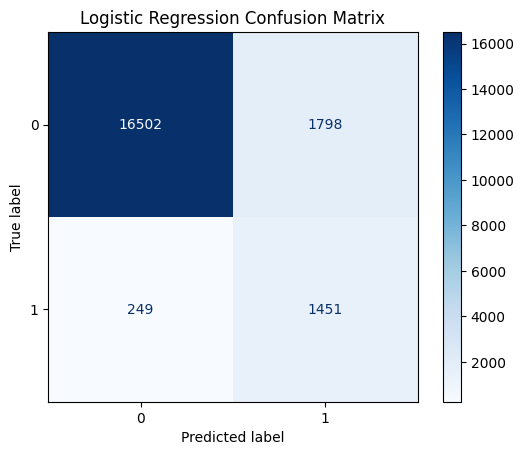

KNN Confusion Matrix


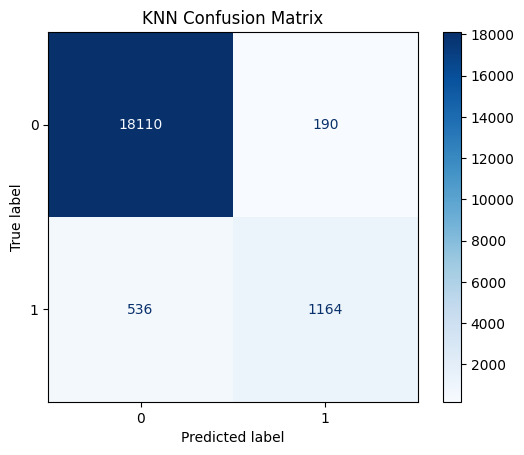

Decision Tree Confusion Matrix


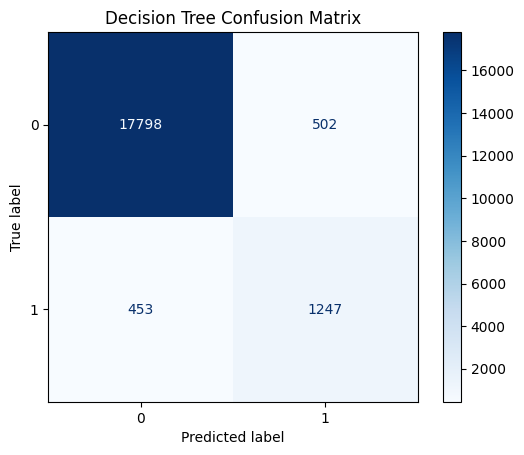

Random Forest Confusion Matrix


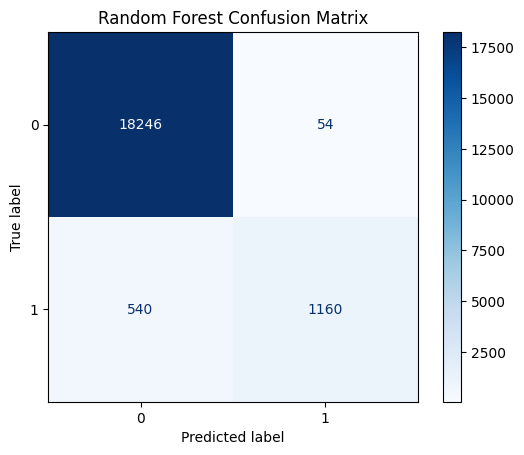

In [35]:
for name, (model, threshold) in final_models.items():
    if threshold:
        y_proba = model.predict_proba(X_test)[:,1]
        y_pred = (y_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
    
    print(f"{name} Confusion Matrix")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} Confusion Matrix")
    plt.show()


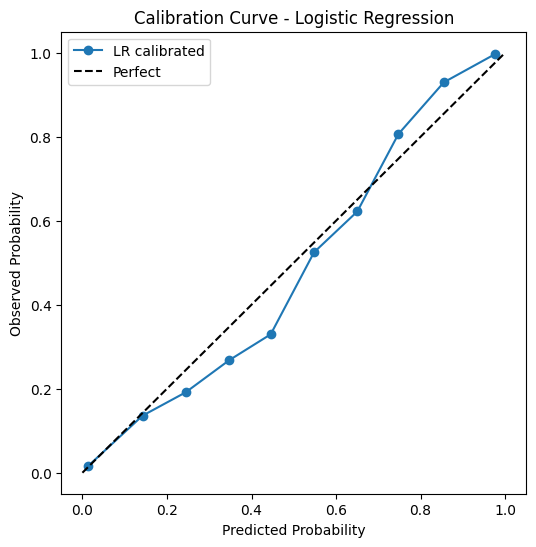

In [36]:
y_proba = final_lr.predict_proba(X_test)[:,1]
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label="LR calibrated")
plt.plot([0,1],[0,1],'k--', label="Perfect")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Probability")
plt.title("Calibration Curve - Logistic Regression")
plt.legend()
plt.show()
